# Train a very simple CNN given two different datasets (fashionMNIST, liveness)

- Read different dataset depending on the option (fashionMNIST, liveness)
    - Define custom dataset first
    - Explore how the dataset is made
    - Make a train_loader
    - Plot images, the whole bach of them
- Define the model
- Train with some kind of simple output
- Eval with a confusion matrix or other metric

In [2]:
DATASET_OPTS = ["fashionMNIST", "liveness"]
DATASET = DATASET_OPTS[0]

import torch


import torchvision
import torchvision.transforms as transforms

### Read different dataset depending on the option (fashionMNIST, liveness)

- Define custom dataset first (in another py file)

In [3]:
if DATASET == "fashionMNIST":
    train_dataset = torchvision.datasets.FashionMNIST(
        root="data/",
        train=True,
        transform=transforms.ToTensor(),
        download=True)
    
    val_dataset = torchvision.datasets.FashionMNIST(
        root='.',
        train=False,
        transform=transforms.ToTensor(),
        download=True)
else:
    from liveness_simple_dataset import LivenessDataset
    train_dataset = LivenessDataset(
        root = "/mnt/data/third_p_simple_dataset/casia/"
    )
    

In [4]:
print(dir(train_dataset))

['__add__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_check_exists', '_check_legacy_exist', '_format_transform_repr', '_is_protocol', '_load_data', '_load_legacy_data', '_repr_indent', 'class_to_idx', 'classes', 'data', 'download', 'extra_repr', 'mirrors', 'processed_folder', 'raw_folder', 'resources', 'root', 'target_transform', 'targets', 'test_data', 'test_file', 'test_labels', 'train', 'train_data', 'train_labels', 'training_file', 'transform', 'transforms']


In [5]:
train_dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
#train_dataset.data.shape # should not use anymore train_data nor test_data, thoser are deprecated

In [7]:
print(train_dataset.targets)

tensor([9, 0, 0,  ..., 3, 0, 5])


In [8]:
train_dataset.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

- Make a train_loader
- Plot images, the whole bach of them

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=32,
                                              shuffle=True)

for inputs, targets in train_loader:
    for img, y in zip(inputs, targets):       
        print(transforms.ToPILImage()(img))
        print(y)
        break
    break


<PIL.Image.Image image mode=L size=28x28 at 0x7F62B2EDF940>
tensor(6)


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# this function will be a life saver
def plot_image_mosaic(images, labels = None, n_columns = 8):
    fig = plt.figure(figsize=(20,16))
    fig.tight_layout()

    #fig.subplots_adjust(bottom=4) # or whatever

    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / n_columns + 1, n_columns, i + 1)
        if labels is not None:
            ax.title.set_text(labels[i])
        if image.shape[2] == 1:
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)

<ipython-input-10-0a6186983ac9>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(len(images) / n_columns + 1, n_columns, i + 1)


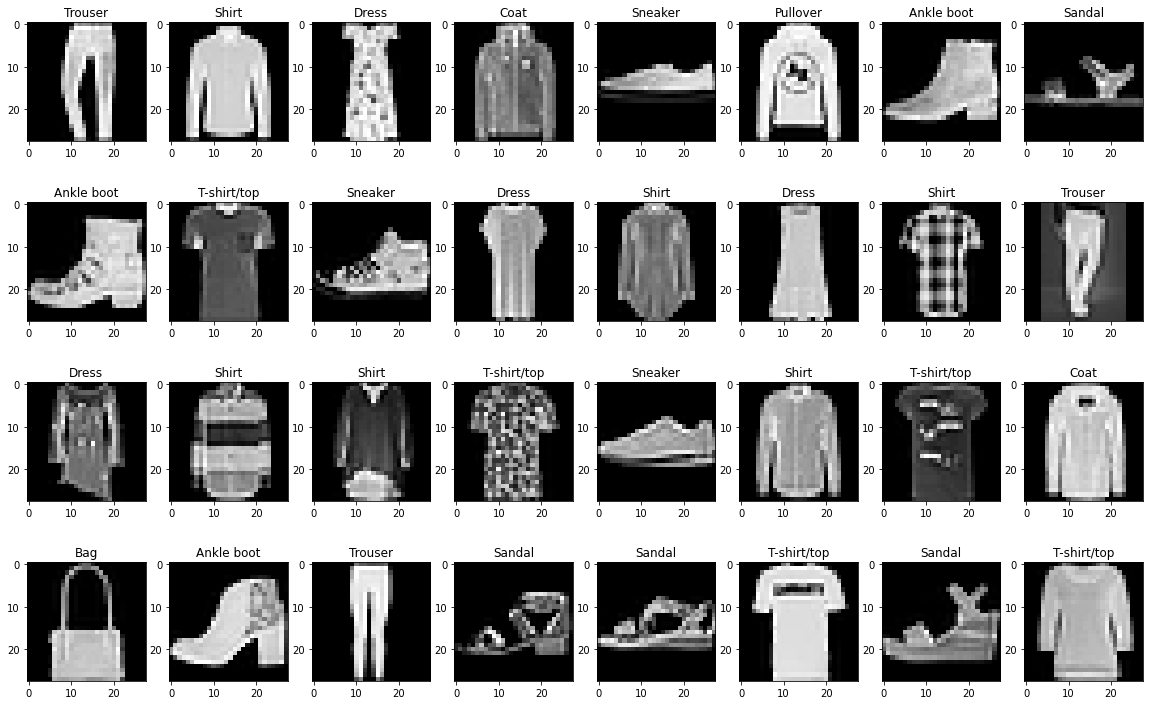

In [11]:
for inputs, targets in train_loader:
    batch_images = []
    for img in inputs:
        # its kind of annoying to convert to numpy back.
        bimg = img.permute(1, 2, 0).numpy() # channel first to channel last
        bimg = (bimg*255).astype("uint8")
        
    batch_images = [img.permute(1, 2, 0).numpy() for img in inputs]
    #print(inputs[0].shape)
    #break
    batch_labels = [train_dataset.classes[int(y)] for y in targets]
    #for img, y in zip(inputs, targets):       
    #    print(transforms.ToPILImage()(img))
    #    print(y)
    #    break
    plot_image_mosaic(batch_images, batch_labels)
    break


### Define the model

In [12]:
import torch.nn as nn


class CNN_Basic(nn.Module):
    
    def __init__(self, K, n_in_channels = 1):
        super(CNN_Basic, self).__init__()
        
        # TODO, how to define in_channels according to the image no. channels?
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=n_in_channels, out_channels=32, kernel_size=3, stride=2), # 32 filters, dont need to define w, h
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2), # 32 filters
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2), # 32 filters
            nn.ReLU()
        )
        
        # TODO: where is the pooling?
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, K)
        )
        
        
    def forward(self, X):
        out = self.conv_layers(X)
        #print("out.size before flatten", out.size)
        #print("out.shape before flatten", out.shape)
        #print("out 0", out.size(0))
        # NOTE: size is an alias for shape, and 0 is the batch size.
        out = out.view(out.size(0), -1) # flatten any 2d tensor
        out = self.dense_layers(out)
        return out
   

model = CNN_Basic(len(train_dataset.classes))
for images, labels in train_loader:
    #example = next(iter(train_loader))[0]
    example = images[0]
    print("example.shape", example.shape)
    out_example = model.forward(example[None,...])
    print("out", out_example)
    print("out.shape", out_example.shape)
    
    # lets see the transformation of input at each layer
    x = example.clone().detach()
    x = x[None,...]
    for layer in model.conv_layers:
        bef_shape = x.shape
        x = layer(x)
        print(f"In: {bef_shape} -> Out: {x.shape}")
    break

example.shape torch.Size([1, 28, 28])
out tensor([[ 0.0193, -0.0495,  0.0577, -0.0340, -0.0116, -0.0163, -0.0262,  0.0058,
          0.0034,  0.0177]], grad_fn=<AddmmBackward0>)
out.shape torch.Size([1, 10])
In: torch.Size([1, 1, 28, 28]) -> Out: torch.Size([1, 32, 13, 13])
In: torch.Size([1, 32, 13, 13]) -> Out: torch.Size([1, 32, 13, 13])
In: torch.Size([1, 32, 13, 13]) -> Out: torch.Size([1, 64, 6, 6])
In: torch.Size([1, 64, 6, 6]) -> Out: torch.Size([1, 64, 6, 6])
In: torch.Size([1, 64, 6, 6]) -> Out: torch.Size([1, 128, 2, 2])
In: torch.Size([1, 128, 2, 2]) -> Out: torch.Size([1, 128, 2, 2])


### TODO
- how to fix visualization for float images in Dataset (make work for gray, color also); DONE
- any way to compute the linear input size automatically; yes, I need to use adpativePooling
- lets train. write as you think it is first;

### Train with some kind of simple output


In [13]:
import time

# NOTE: important, move the model to GPU if available, takes some time.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

start = time.time()
model.to(device)
print(f"Elapsed time: {(time.time() - start)}s")

cuda:0
Elapsed time: 2.9181342124938965s


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)


In [15]:
import numpy as np

n_epochs = 10

train_losses = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs) # TODO eval

for i in range(n_epochs):
    # model.train() tells your model that you are training the model. So effectively layers 
    # like dropout, batchnorm etc. which behave different on the train and test procedures 
    # know what is going on and hence can behave accordingly.
    model.train()
    
    train_losses = []
    for inputs, targets in train_loader: # for each batch!
        # needs to move data to GPU myself
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad() # each batch is new grad for the parameters (this is not an RNN)
        
        # foward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # computer grads and make a gradient descent
        loss.backward() # compute gradients
        optimizer.step() # use gradients to updata parameters
        
        train_losses.append(loss.item())
        
    # I got every single train loss for each batch, now I should average them
    # to see how Im going
    avg_train_loss = np.mean(train_losses)
    
    print(f"Epoch {i}/{n_epochs}, train loss: {avg_train_loss:.2f}")

    # evaluate model
    model.eval()
    
        


Epoch 0/100, train loss: 0.86
Epoch 1/100, train loss: 0.51
Epoch 2/100, train loss: 0.44
Epoch 3/100, train loss: 0.41
Epoch 4/100, train loss: 0.38
Epoch 5/100, train loss: 0.36
Epoch 6/100, train loss: 0.35
Epoch 7/100, train loss: 0.33
Epoch 8/100, train loss: 0.32
Epoch 9/100, train loss: 0.31
Epoch 10/100, train loss: 0.30
Epoch 11/100, train loss: 0.29
Epoch 12/100, train loss: 0.28
Epoch 13/100, train loss: 0.27
Epoch 14/100, train loss: 0.26
Epoch 15/100, train loss: 0.25
Epoch 16/100, train loss: 0.25
Epoch 17/100, train loss: 0.24
Epoch 18/100, train loss: 0.23
Epoch 19/100, train loss: 0.22
Epoch 20/100, train loss: 0.22
Epoch 21/100, train loss: 0.21
Epoch 22/100, train loss: 0.20
Epoch 23/100, train loss: 0.20
Epoch 24/100, train loss: 0.19
Epoch 25/100, train loss: 0.18
Epoch 26/100, train loss: 0.18
Epoch 27/100, train loss: 0.18
Epoch 28/100, train loss: 0.17
Epoch 29/100, train loss: 0.16
Epoch 30/100, train loss: 0.16
Epoch 31/100, train loss: 0.15
Epoch 32/100, trai

KeyboardInterrupt: 